In [1]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, Callback
from keras.utils import image_dataset_from_directory
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model, load_model
from keras.applications import DenseNet121
from scikitplot.metrics import plot_confusion_matrix, plot_roc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_directory = "/kaggle/input/geoguessr-55countries/geoguessr_filtered_data"

batch_size = 32
img_width = 1536
img_height = 662
epochs = 30

img_target_scale = 0.2
img_target_width = int(math.floor(img_width * img_target_scale))
img_target_height= int(math.floor(img_height * img_target_scale))

train_ds = image_dataset_from_directory(
  data_directory,
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_target_height, img_target_width),
  batch_size=batch_size)

validation_ds = image_dataset_from_directory(
  data_directory,
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_target_height, img_target_width),
  batch_size=batch_size)

classes = train_ds.class_names

Found 35977 files belonging to 55 classes.
Using 28782 files for training.
Found 35977 files belonging to 55 classes.
Using 7195 files for validation.


In [3]:
base_model = DenseNet121(
    include_top=False,
    input_shape=(img_target_height,img_target_width,3),
)

trainable_layers = 5
for layer_index in range(len(base_model.layers) - trainable_layers):
    base_model.layers[layer_index].trainable = False

dropout_rate = 0.45
dropout_layer = Dropout(dropout_rate)(base_model.layers[-1].output)
flattened_base = Flatten()(dropout_layer)
output_layer = Dense(len(train_ds.class_names), activation="softmax")(flattened_base)
model = Model(inputs=base_model.inputs, outputs=output_layer)

29084464/29084464 [==============================] - 0s 0us/step


In [4]:
early_stopping = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=3, 
                           restore_best_weights=True)

In [5]:
model.compile(loss="categorical_crossentropy", 
              optimizer="adam",
              metrics=["accuracy", "top_k_categorical_accuracy"])

history = model.fit(train_ds,
              epochs=epochs,
              callbacks=[early_stopping],
              validation_data=validation_ds)

model.save("model.h5")

Epoch 1/30
900/900 [==============================] - 2786s 3s/step - loss: 10.0187 - accuracy: 0.1483 - top_k_categorical_accuracy: 0.4168 - val_loss: 7.8598 - val_accuracy: 0.1872 - val_top_k_categorical_accuracy: 0.4863
Epoch 2/30
900/900 [==============================] - 2684s 3s/step - loss: 6.2739 - accuracy: 0.2502 - top_k_categorical_accuracy: 0.5824 - val_loss: 6.3097 - val_accuracy: 0.2278 - val_top_k_categorical_accuracy: 0.5383
Epoch 3/30
900/900 [==============================] - 2695s 3s/step - loss: 4.4008 - accuracy: 0.3196 - top_k_categorical_accuracy: 0.6785 - val_loss: 5.5778 - val_accuracy: 0.2505 - val_top_k_categorical_accuracy: 0.5566
Epoch 4/30
900/900 [==============================] - 2621s 3s/step - loss: 3.2972 - accuracy: 0.3760 - top_k_categorical_accuracy: 0.7426 - val_loss: 4.8595 - val_accuracy: 0.2632 - val_top_k_categorical_accuracy: 0.5796
Epoch 5/30
900/900 [==============================] - 2627s 3s/step - loss: 2.5348 - accuracy: 0.4383 - top_k_c

In [6]:
validation_performance = model.evaluate(validation_ds)
validation_performance

225/225 [==============================] - 516s 2s/step - loss: 3.9173 - accuracy: 0.2859 - top_k_categorical_accuracy: 0.6021


[3.917275905609131, 0.2858929932117462, 0.602084755897522]

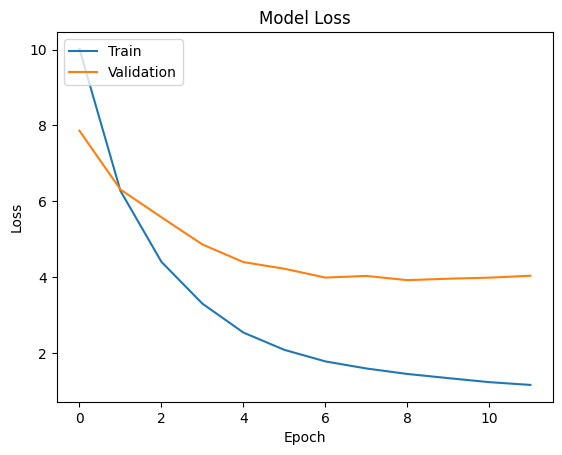

In [7]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

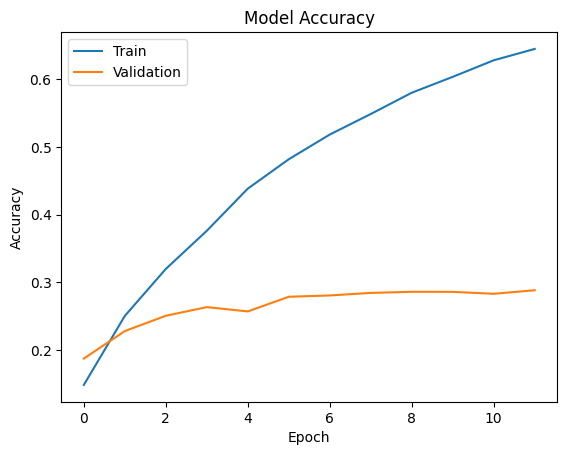

In [8]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()